## Model for predicting approval

Here we are trying to predict via personal info whether or not one could be approved for credit card.

Problem statement: According to the Consumer Financial Protection Bureau, approximately 45 million Americans do not have a credit score, preventing most from obtaining mortgages, car loans, and even personal loans. This problem stems from a lack of financial literacy among Americans and it’s costing millions of households thousands of dollars every year. The easiest way to build credit is through credit cards, where people can develop a credit history and improve their credit over time. Before applying for credit, people must meet a certain set of criteria like age of credit, income, cost of housing, etc. This data is then used by banks to determine credit worthiness and applicants are either approved or denied, with very little feedback given to applicants who were denied. We propose an ML model to help applicants gauge their creditworthiness before applying, helping them avoid an unnecessary credit score drop from a hard pull on their credit report.


### DATA preprocessing

In [1]:
import numpy as np
import pandas as pd   
import seaborn as sns
import matplotlib.pyplot as plt
credit = pd.read_csv('credit_record.csv')  
application = pd.read_csv('application_record.csv')

print(credit.count())
credit.head()
print("\n")
print(application.count())


ID                1048575
MONTHS_BALANCE    1048575
STATUS            1048575
dtype: int64


ID                     438557
CODE_GENDER            438557
FLAG_OWN_CAR           438557
FLAG_OWN_REALTY        438557
CNT_CHILDREN           438557
AMT_INCOME_TOTAL       438557
NAME_INCOME_TYPE       438557
NAME_EDUCATION_TYPE    438557
NAME_FAMILY_STATUS     438557
NAME_HOUSING_TYPE      438557
DAYS_BIRTH             438557
DAYS_EMPLOYED          438557
FLAG_MOBIL             438557
FLAG_WORK_PHONE        438557
FLAG_PHONE             438557
FLAG_EMAIL             438557
OCCUPATION_TYPE        304354
CNT_FAM_MEMBERS        438557
dtype: int64


Here we can see a differnet count between the two files we are using, This can be attributed to how the credit_record.csv is formatted but as we will see the credit_record.csv does not contain all the IDs that application_record.csv contains

In [2]:
creditIDs=credit.ID.unique()
applicationIDs=application.ID.unique()
totalIDsDiff= np.setdiff1d(applicationIDs,creditIDs)
# here applicationIDs has alot more IDs that creditIDS doesnt so we will remove those
print("number of differnet IDs in application")
print(len(totalIDsDiff))

f_df=application[application.ID.isin(totalIDsDiff)]
filtered_application=pd.concat([application, f_df, f_df]).drop_duplicates(keep=False)


totalIDsDiff= np.setdiff1d(creditIDs,applicationIDs)
print("\nnumber of differnet IDs in credit")
print(len(totalIDsDiff))

f_df=credit[credit.ID.isin(totalIDsDiff)]
filtered_credit=pd.concat([credit, f_df, f_df]).drop_duplicates(keep=False)

creditIDs=filtered_credit.ID.unique()
applicationIDs=filtered_application.ID.unique()

totalIDsDiff= np.setdiff1d(applicationIDs,creditIDs)
print("\nnumber of differnet IDs in application")
print(len(totalIDsDiff))

totalIDsDiff= np.setdiff1d(creditIDs,applicationIDs)
print("\nnumber of differnet IDs in credit")
print(len(totalIDsDiff))
len(filtered_credit.ID.unique())
# Note that if you have a better way to filter the dataframe please do it because this method isin is very slow
# TODO: drop NAN, fix days employed, fix Occupation_type

number of differnet IDs in application
402053

number of differnet IDs in credit
9528

number of differnet IDs in application
0

number of differnet IDs in credit
0


36457

After that there are 2 more preprocessing steps I have identified so far, there could be more. However, we need to preform a vintage anyalysis on the Credit_record.csv to create the label in which we will be predicting and then we have to remove some Null values.

Note for for the vintage anaylsis, this data set doesn not contain a label that tells if someone has been approved. Intsead it contains their loan record. We could have choosen a differnet data set with the label that tells if someone has been approved, but like in real scenarios the data being used might not always be complete. So instead we are using Vintage Analysis to preform some data processing on the credit record to create a label that would mimic a credit card approved label. Vintage Analysis is one of many popular methods for accessing credit risk. It is used to determine the number of months' data you should consider for performance window. If customer defaults (90 days or more past due) during the performance window, borrower would be considered as a risk and would more likely be declined for credit card approval. We will use this combinedd with a proportion of the customers past due to determine their likelyhood of being approved for credit or not. 1 being that they meet all criteria to being approved and 0 being that they are not apporved.

NOTE: to reader do not include in final submit

What is our model doing then? like what is our justification to our model? If the Vintage analysis already exists where a user doesnt need to pull credit instead provide loan info they can get an accurate guess of approval?

My own thought about this is that, we are trying to connect the labels in application_record.csv to credit approval through connecting the labels to loan history to approval. So no we dont even need loan history, just the labels we decide to use?

I am not quite sure if that makes sense tbh, like are we allowed to make that connection/assumption? so what we are really doing is predicting good or bad loan history based on these labels if we do this?

-Patrick

# link

link to the vintage analysis the author of the dataset does
https://www.kaggle.com/code/rikdifos/eda-vintage-analysis

I looked over this and it still just seems that they set anyone over 60 days past due to be a bad customer?

are we allowed to do this kinda target label creation? It seems kind of arbitrary to me tbh.

We should also start a LaTex for this because thats what she asks for.

need some refrence like research papers, different methods on how we approached this which for us will probably include alot of data processing and figures. We will using supervised learning I think. The link I provided has some nice figures and explination on what they do for preprocessing.

In [3]:
filtered_application
filtered_credit

# fill Occupation NA
filtered_application.isnull().sum()


ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
dtype: int64

In [4]:

filtered_application['OCCUPATION_TYPE'].fillna(value='Not identified', inplace=True)


 we need to determine who is a bad or good approval. I will be using a very simple 
determination via late loan payments

according to vary sources late payments 60 days or later will have extra affects on your score and in some cases late payements over 90 can cause your account to default, which can cause even more devestating affects on your credit account. So, I will split the credit status up

{'C' : 1,

'X' : 0,

'0' : -1,

'1' : -2,

'2' : -3,

'3' : -4,

'4' : -5,

'5' : -6}

Then I will add up the values per ID and if the total debt value is less than 0 then they will be considered not approved or will not be approved

NOTE: if anyone can find any revelance to how old your account affects your credit please add it

MORE NOTES:

Originally

{'C' : 1,

'X' : 1,

'0' : 1,

'1' : -1,

'2' : -1,

'3' : -3,

'4' : -3,

'5' : -3}


But this lead tooo wayyyy oversampleing of 1 meaning over 99 percent were being approved which did not seem right to me

In [5]:
My_credit_Dict = {'C' : 1,
               'X' : 0,
               '0' : -1,
               '1' : -2,
               '2' : -3,
               '3' : -4,
               '4' : -5,
               '5' : -6}
filtered_credit.replace({'STATUS' : My_credit_Dict }, inplace=True)
new_filtered_credit = filtered_credit.value_counts(subset=['ID', 'STATUS']).unstack(fill_value=0)
print(new_filtered_credit)

new_filtered_credit.loc[(new_filtered_credit[1]-new_filtered_credit[-1]-(2*new_filtered_credit[-2])-(3*new_filtered_credit[-3]) >= 0)-(4*new_filtered_credit[-4])-(5*new_filtered_credit[-5])-(6*new_filtered_credit[-6]) > 0, 'APPROVAL_STATUS'] = 1
new_filtered_credit.loc[(new_filtered_credit[1]-new_filtered_credit[-1]-(2*new_filtered_credit[-2])-(3*new_filtered_credit[-3]) >= 0)-(4*new_filtered_credit[-4])-(5*new_filtered_credit[-5])-(6*new_filtered_credit[-6]) < 0, 'APPROVAL_STATUS'] = 0
new_filtered_credit['APPROVAL_STATUS'].value_counts(normalize=True)
#NOte this is still horribly oversampled? lol that is kinda bad. We will need to use something to counter act that

STATUS   -6  -5  -4  -3  -2  -1   0   1
ID                                     
5008804   0   0   0   0   1   1   1  13
5008805   0   0   0   0   1   1   1  12
5008806   0   0   0   0   0   7  16   7
5008808   0   0   0   0   0   2   3   0
5008809   0   0   0   0   0   0   5   0
...      ..  ..  ..  ..  ..  ..  ..  ..
5150482   0   0   0   0   0  12   0   6
5150483   0   0   0   0   0   0  18   0
5150484   0   0   0   0   0  12   0   1
5150485   0   0   0   0   0   2   0   0
5150487   0   0   0   0   0   0   0  30

[36457 rows x 8 columns]


1.0    0.982265
0.0    0.017735
Name: APPROVAL_STATUS, dtype: float64

# How to deal with oversampling
https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

From here I would drop the -6-1 columns then combine the approval status with application and then build a tree to maybe view and feature importance and maybe build some other models. then rebuild them with removed features tbh. end of credit_csv processing, should combine with applicaiton but I want to mess with that one as well before.

In [6]:
filtered_application.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           19
CNT_FAM_MEMBERS           10
dtype: int64

FLAG_MOBIL only has one value which means it is unnecessary.

Besides that I dont want to get rid of any other labels until we can have a rough estimate of their correlation.

Next we will explore some interesting numerical date that through intuition might have an affect on credit and are not just flag labels. So labels like income, name income, days employed, occupation, age, and eduaction.

In [7]:
filtered_application.drop('FLAG_MOBIL', axis=1, inplace = True)

Now lets take a look at the occupations and income

['Not identified' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']
['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']


C:\Users\patch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


array([[<AxesSubplot:title={'center':'Commercial associate'}>,
        <AxesSubplot:title={'center':'Pensioner'}>],
       [<AxesSubplot:title={'center':'State servant'}>,
        <AxesSubplot:title={'center':'Student'}>],
       [<AxesSubplot:title={'center':'Working'}>, <AxesSubplot:>]],
      dtype=object)

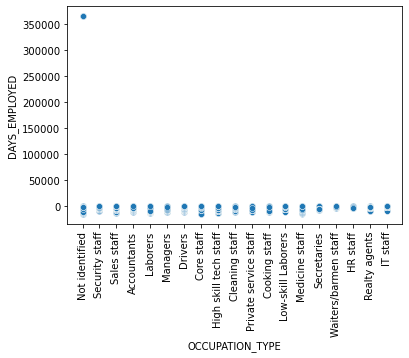

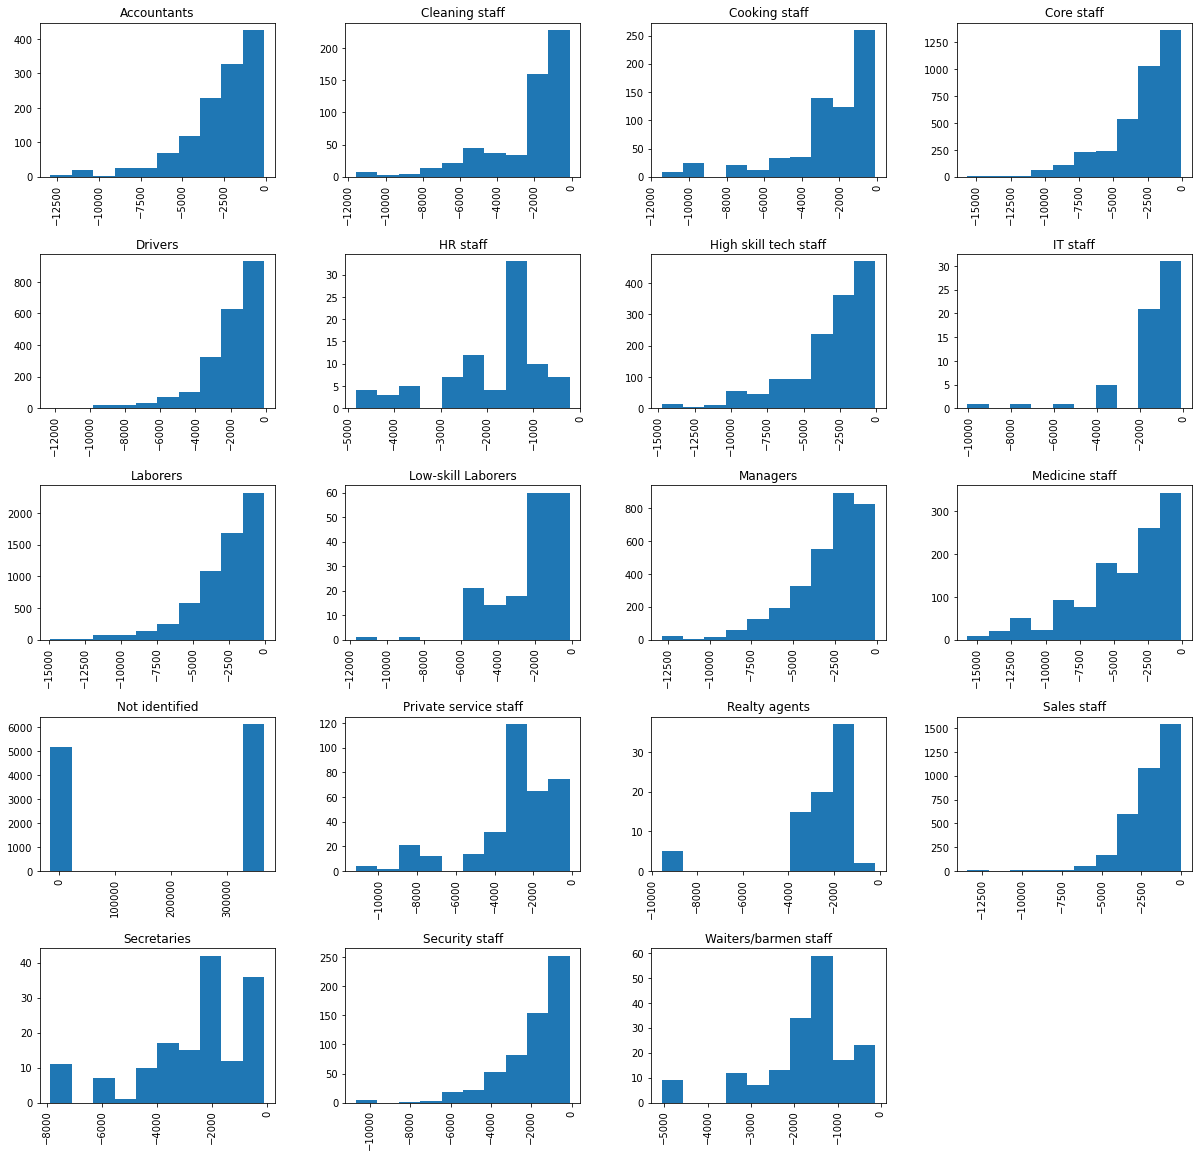

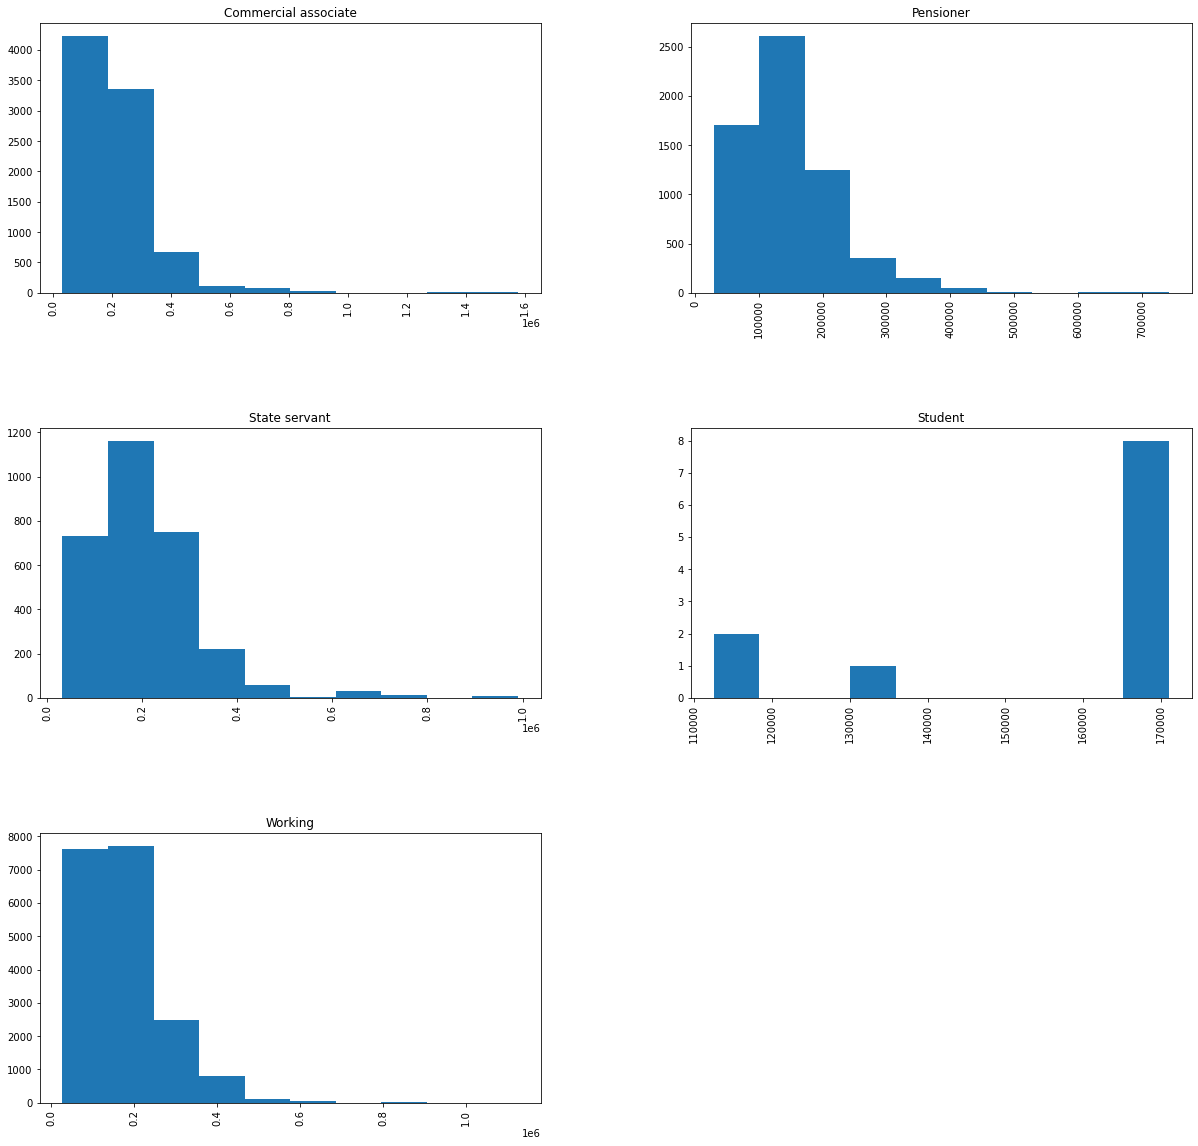

In [20]:
print(filtered_application['OCCUPATION_TYPE'].unique())
print(filtered_application['NAME_INCOME_TYPE'].unique())

#this is a bad plot lol will probably get rid of this one lmao
plt=sns.scatterplot(filtered_application['OCCUPATION_TYPE'],filtered_application['DAYS_EMPLOYED'])
plt.tick_params(axis='x', rotation=90)

#better looking plot lmao
filtered_application[['OCCUPATION_TYPE','DAYS_EMPLOYED']].hist(by='OCCUPATION_TYPE', figsize=(20, 20))

filtered_application[['NAME_INCOME_TYPE','AMT_INCOME_TOTAL']].hist(by='NAME_INCOME_TYPE', figsize=(20, 20))

The Occupation types does seems fine as most of the occupations are general. However name_income type seem to be thrown off as students are an income type? So lets explore that and besides that some DAYS_EMPLOYED is skewing this plot as seen in the NOT IDENTified label

In [21]:

print(filtered_application['NAME_INCOME_TYPE'].value_counts())

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64


I admit it is weird to have 11 students have over 11000k in income amount per year but its not such a common outlier that we have to remove it. The Not identified poses a larger problem as some people are set to a postive number which is impossible, because DAYS_EMPLOYED is negative meaning the application started work -x days ago, so a positive number means they have worked negative days. Note we could just eliminate all those who have this label but we can first try to pinpoint the problem. By instead looking at the days work and name income, instead of Occupation

array([[<AxesSubplot:title={'center':'Commercial associate'}>,
        <AxesSubplot:title={'center':'Pensioner'}>],
       [<AxesSubplot:title={'center':'State servant'}>,
        <AxesSubplot:title={'center':'Student'}>],
       [<AxesSubplot:title={'center':'Working'}>, <AxesSubplot:>]],
      dtype=object)

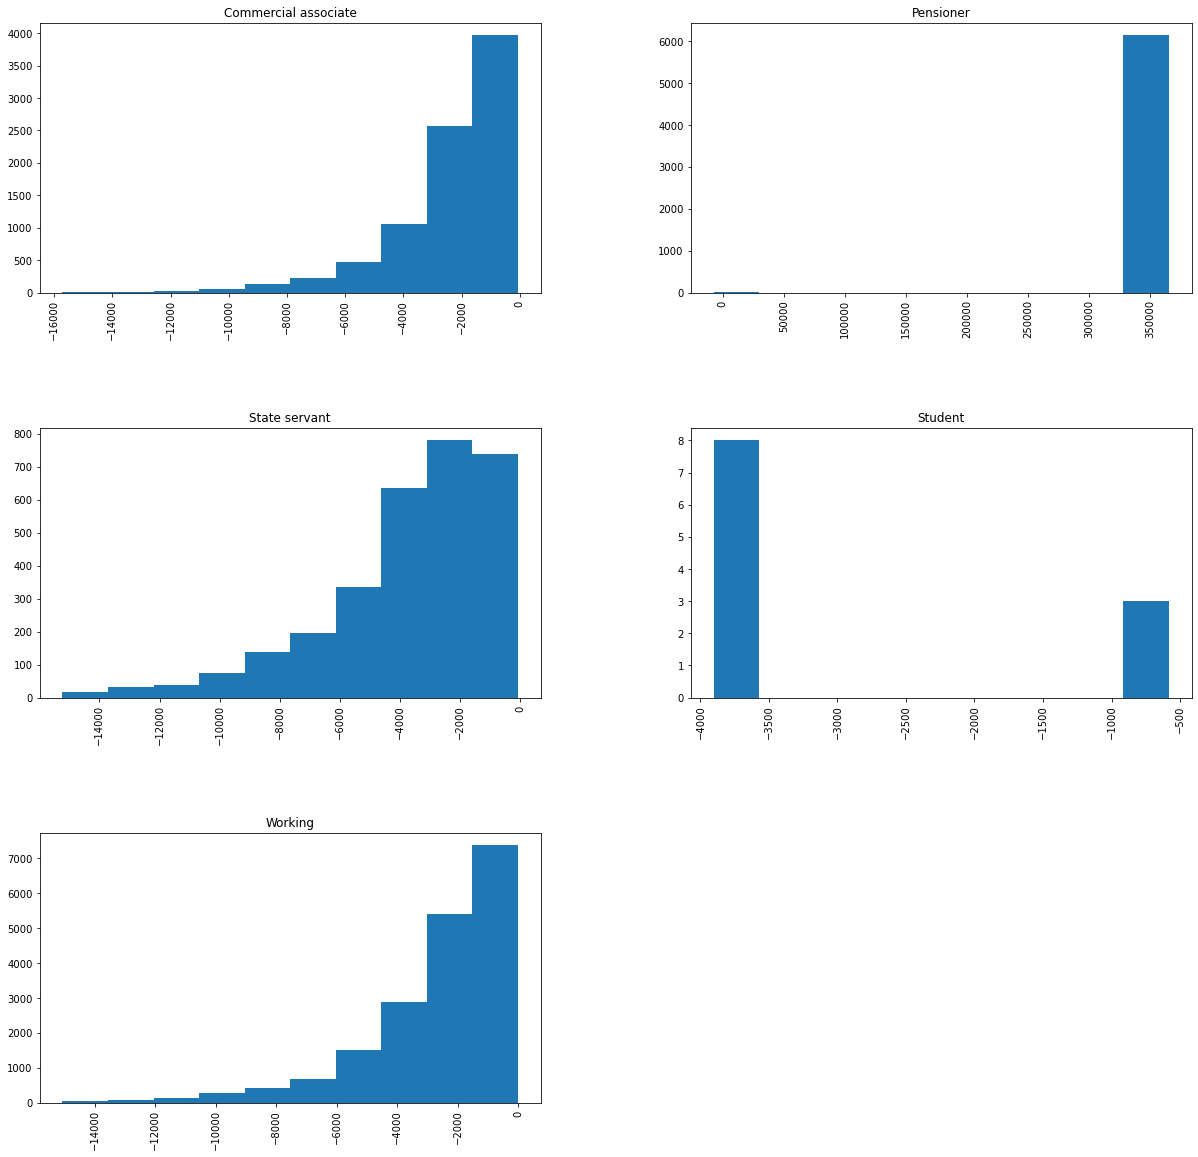

In [23]:
filtered_application[['NAME_INCOME_TYPE','DAYS_EMPLOYED']].hist(by='NAME_INCOME_TYPE', figsize=(20, 20))


Here we can clearly see that pensioners are set to this value that is suppposed to be impossible, so instead we can instead change the pensioners days employed to zero instead of eliminating those data points. Besides that we should also change days employed to years, with to the closest year as the exact date of employment is less known by users(unsure if we should do this). Also maybe want to either label encode or one hot encode the flag values for more data processing